In [6]:
import sklearn
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

import torch
from torch import nn

# Create Data

In [7]:
n_samples=1000
x, y = make_circles(n_samples=n_samples,
                    noise=0.05,
                    random_state=42)
len(x), len(y)

(1000, 1000)

In [8]:
circles = pd.DataFrame({'X1': x[:,0],
                        'X2': x[:,1],
                       'label': y})
circles.head()

,X1,X2,label
0,0.742207,0.246686,1
1,-0.734032,0.168692,1
2,-0.829859,0.221959,1
3,-0.429136,0.672230,1
4,0.445602,-0.894936,0


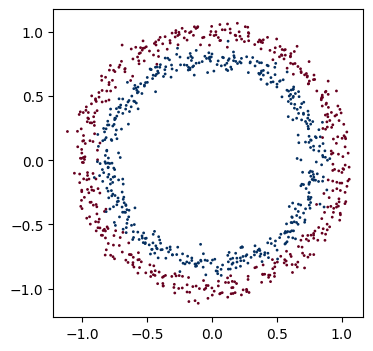

In [9]:
fig = plt.figure(figsize=(4,4))
plt.scatter(x[:,0], x[:,1], c=y, s=1, cmap=plt.cm.RdBu)

# Convert Data

In [10]:
type(x)

numpy.ndarray

In [11]:
X = torch.from_numpy(x).type(torch.float)
Y = torch.from_numpy(y).type(torch.float)

In [12]:
X.type(), Y.dtype

('torch.FloatTensor', torch.float32)

# Configurations

In [13]:
test_ratio = 0.2
LearningRate = 0.1
EPOCHS = 200

loss_fn = nn.MSELoss()

In [14]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE

'cuda'

In [15]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_ratio)
len(X), len(Y), len(X_train), len(Y_train), len(X_test), len(Y_test) 

(1000, 1000, 800, 800, 200, 200)

# Class module

In [16]:
class CircleClassifierModule(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x:torch.Tensor, Y_train=None) -> torch.Tensor:
        if Y_train is None:
            return self.model(x).squeeze()
        else:
            y_preds = self.model(x).squeeze()
            loss = loss_fn(y_preds, Y_train)
            return y_preds, loss

In [17]:
model_0 = CircleClassifierModule().to(device=DEVICE)
model_0.state_dict()

OrderedDict([('model.0.weight', tensor([[-0.0160, -0.6059]], device='cuda:0')),
             ('model.0.bias', tensor([-0.5603], device='cuda:0'))])

In [22]:
optimizer = torch.optim.Adam(model_0.parameters(), lr=LearningRate)
train_loss_values = []
test_loss_values = []
total_epochs = 0

# Trianing Loop

In [26]:
X_train = X_train.to(device=DEVICE)
Y_train = Y_train.to(device=DEVICE)
X_test = X_test.to(device=DEVICE)
Y_test = Y_test.to(device=DEVICE)

for epoch in range(EPOCHS):
    model_0.train()
    
    Y_preds, loss = model_0.forward(X_train*X_train, Y_train)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    model_0.eval()
    
    with torch.inference_mode():
        Y_test_preds = model_0.forward(X_test*X_test).squeeze()
        test_loss = loss_fn(Y_test_preds, Y_test)
        if epoch % 10==0:
            print(f"Epoch:{epoch} , Train Loss:{loss} , Test Loss:{test_loss}")
        train_loss_values.append(loss.cpu())
        test_loss_values.append(test_loss.cpu())
        
total_epochs += EPOCHS

Epoch:0 , Train Loss:0.26723238825798035 , Test Loss:0.2559469938278198
Epoch:10 , Train Loss:0.23289959132671356 , Test Loss:0.23222313821315765
Epoch:20 , Train Loss:0.20296595990657806 , Test Loss:0.20547309517860413
Epoch:30 , Train Loss:0.17498742043972015 , Test Loss:0.1763058751821518
Epoch:40 , Train Loss:0.15110647678375244 , Test Loss:0.15279355645179749
Epoch:50 , Train Loss:0.13148917257785797 , Test Loss:0.13345736265182495
Epoch:60 , Train Loss:0.11570605635643005 , Test Loss:0.11850439012050629
Epoch:70 , Train Loss:0.10309045761823654 , Test Loss:0.10620826482772827
Epoch:80 , Train Loss:0.09296207129955292 , Test Loss:0.09640415012836456
Epoch:90 , Train Loss:0.08474981039762497 , Test Loss:0.08837056905031204
Epoch:100 , Train Loss:0.07800696045160294 , Test Loss:0.08186779171228409
Epoch:110 , Train Loss:0.07239732891321182 , Test Loss:0.07642526924610138
Epoch:120 , Train Loss:0.06767088919878006 , Test Loss:0.07185675948858261
Epoch:130 , Train Loss:0.0636415183544

In [27]:
model_0.state_dict()

OrderedDict([('model.0.weight',
              tensor([[-10.0335,  -9.8505]], device='cuda:0')),
             ('model.0.bias', tensor([8.0178], device='cuda:0'))])

# Plot

Text(0, 0.5, 'Loss')

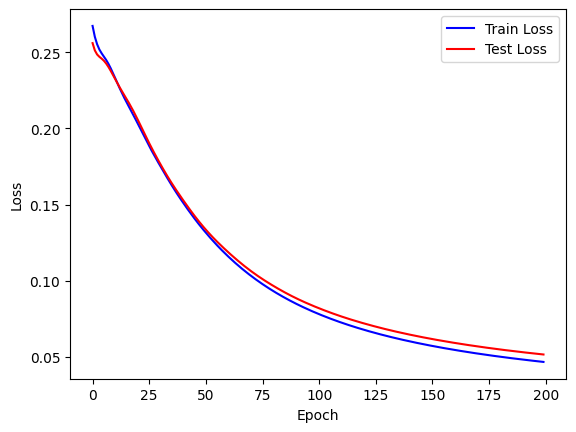

In [28]:
plt.plot(range(total_epochs), train_loss_values, c='b', label = 'Train Loss')
plt.plot(range(total_epochs), test_loss_values, c='r', label = 'Test Loss')
plt.legend(); plt.xlabel('Epoch'); plt.ylabel('Loss')

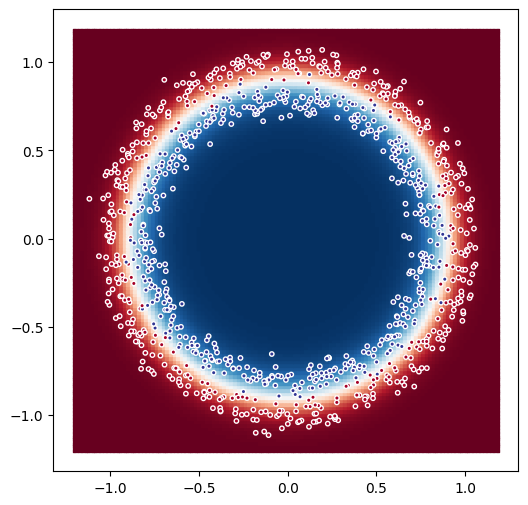

In [30]:
# Make gridspace
step = 0.02
x_linespace = np.arange(-1.2, 1.2, step)
y_linespace = np.arange(-1.2, 1.2, step)
x_linespace, y_linespace = np.meshgrid(x_linespace, y_linespace)
points = np.array([[x_linespace.flatten()[i], y_linespace.flatten()[i]] for i in range(len(x_linespace.flatten()))])

# Calculate predictions at each point
tensor_points = torch.tensor(points).type(torch.float).to(DEVICE)
with torch.inference_mode():
    Y_points = model_0.forward(tensor_points*tensor_points)
Y_points = Y_points.to('cpu')

# Plot grid space predictions along with original data
fig = plt.figure(figsize=(6,6))
plt.scatter(points[:,0], points[:,1], s = 4, marker='s', c=Y_points, cmap=plt.cm.RdBu)
plt.scatter(x[:,0], x[:,1], s=10, c=y, edgecolors='w', linewidths=1, cmap=plt.cm.RdYlBu)

In [32]:
# Save the model
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "model_binary_class.pt"
MODEL_SAVE_PATH = MODEL_PATH/MODEL_NAME

torch.save(obj=model_0.state_dict(), f=MODEL_SAVE_PATH)